`# ME5413: Autonomous Mobile Robot  

### Homework 1: Perception  
Due date: 22 February 2024 (Thurs) - 2359 `

### Task 1.1 Single-Object Tracking 

#### Preparation

**Import the necessary packages**

In [25]:
import cv2
import numpy as np
import glob
from utils.load import *
from utils.save import *
from utils.evaluate import *

**Load (and Test) the original frames**

The original frames are stored in the folder `./data`. I define the variable `images` to store the original frames, and then use `cv2.imshow()` to display the original videos.

In [26]:
# load the frames
seq_index = "5"
seq_folder_path = 'data/seq_' + seq_index
image_files = glob.glob(seq_folder_path + '/img' + '/*.jpg')
image_files.sort()

images = []
for image_files in image_files:
    image = cv2.imread(image_files)
    images.append(image)

In [27]:
# Create a template from the first frame
x, y, w, h = load_firsttrack(seq_folder_path + '/firsttrack.txt')

#### Using Kalman Filter

**Kalman Filter**

Kalman Filter is a recursive algorithm that estimates the state of a process. It is a linear quadratic estimator that estimates the state of a linear dynamic system from a series of noisy measurements. The Kalman Filter is initialized with the following parameters:
+ State transition matrix, A
+ Control matrix, B
+ Measurement matrix, H
+ Process noise covariance, Q
+ Measurement noise covariance, R
+ Error covariance, P
+ Initial state, x

**Initilize the Kalman Filter**


In [28]:
# Define the Kalman filter
kf = cv2.KalmanFilter(4, 4)

# Initial state (x, y, w, h) representing the location(TopLight) and size of the bounding box
kf.statePre = np.array([x, y, w, h], np.float32)

# Initial state estimation error covariance
kf.processNoiseCov = np.array([[1, 0, 0, 0],
                               [0, 1, 0, 0],
                               [0, 0, 1, 0],
                               [0, 0, 0, 1]], np.float32)

# Transition matrix
kf.transitionMatrix = np.array([[1, 0, 0, 0],
                                [0, 1, 0, 0],
                                [0, 0, 1, 0],
                                [0, 0, 0, 1]], np.float32)

# Measurement matrix
kf.measurementMatrix = np.array([[1, 0, 0, 0],
                                [0, 1, 0, 0],
                                [0, 0, 1, 0],
                                [0, 0, 0, 1]], np.float32)

# Measurement noise covariance
kf.measurementNoiseCov = np.array([[1, 0, 0, 0],
                                   [0, 1, 0, 0],
                                   [0, 0, 1, 0],
                                   [0, 0, 0, 1]], np.float32)

+ Create the dummy sensor as measurement from the `groundtruth.txt` file

In [29]:
# measurement (dummy sensor based on the ground truth)
measurements = load_tracks_with_gaussian_noise(seq_folder_path + '/groundtruth.txt')

+ Tracking with Kalman Filter (Measured by the dummy sensor)

In [30]:
# Initialize the list to store the detections
detections = []

# Process the frames
for img, measurement in zip(images, measurements):
    # Kalman correction
    measurement = np.array([measurement[0], measurement[1], measurement[2], measurement[3]], np.float32)
    kf.correct(measurement)

    # Predict the next state
    prediction = kf.predict()

    # Draw rectangle around the predicted location
    top_left = (int(prediction[0]), int(prediction[1]))
    bottom_right = (int(prediction[0] + prediction[2]), int(prediction[1] + prediction[3]))
    img_copy = img.copy()
    cv2.rectangle(img_copy, top_left, bottom_right, 255, 2)

    # Store the detections
    detections.append((top_left[0], top_left[1], int(prediction[2]), int(prediction[3])))

    # cv2.imshow('image', img_copy)
    # if cv2.waitKey(50) & 0xFF == ord('q'):
    #     break

cv2.destroyAllWindows()

# After processing all frames, save the detections to a text file
save_detections(detections,  seq_folder_path + '/detections_kf.txt')

**Evaluate the performance of the Single object tracking algorithm.**

Evaluate the performance of template matching and Kalman filter. The evaluation should include the following:
+ The accuracy of the tracking algorithm
+ The robustness of the tracking algorithm
+ The efficiency of the tracking algorithm


In [31]:
# Load the ground truth and the detections
groundtruth = load_tracks(seq_folder_path + '/groundtruth.txt')
detections_kf = load_tracks(seq_folder_path + '/detections_kf.txt')

# Return the average IoU
average_iou_kf = evaluate_average_iou(detections_kf, groundtruth)


**Visualise the results as well**.


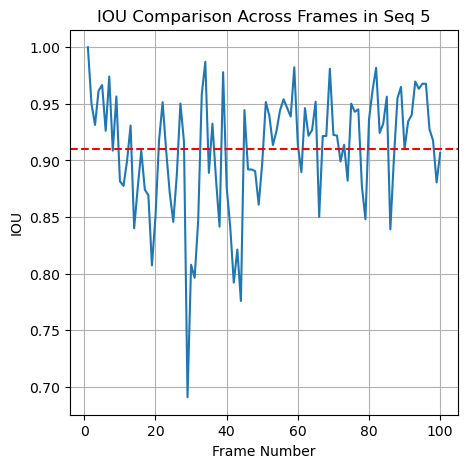

In [32]:
visualize_iou(detections_kf, groundtruth, "IOU Comparison Across Frames in Seq " + seq_index)

Propose Improvements to the work if possible: